In [1]:
import csv
import pandas as pd
from collections import defaultdict
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


# File paths
wordcounts_file = 'word_counts.txt'
replacement_words_file = 'replacement_words.csv'
output_lift_values = 'Lift_Values.csv'
output_lift_matrix = 'Lift_Matrix.csv'
input_file = 'replacement_sample_data.csv'  # Corrected to your file

def clean_text(text):
    # Remove punctuation, convert to lowercase, and remove stopwords
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return [word for word in text.split() if word not in stop_words]

def load_word_counts(filename):
    word_counts = {}
    with open(filename, 'r') as file:
        for line in file:
            try:
                word, count = line.strip().split(',')
                word_counts[word] = int(count)
            except ValueError:
                # Ignore lines with errors (invalid format)
                continue
    return dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

def load_replacement_words(filename):
    df = pd.read_csv(filename)
    valid_brands = set(df['Brand'].unique())
    valid_brands -= {'car', 'seat', 'problem', 'sedan'}  # Exclude unwanted words
    return valid_brands

def get_top_brands(word_counts, valid_brands):
    top_brands = [word for word in word_counts if word in valid_brands]
    return top_brands[:10]  # Limit to 10 brands

def process_input_file(input_filename):
    posts = []
    with open(input_filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            post = clean_text(row[1])  # Assuming post text is in the second column
            posts.append(post)
    return posts

def calculate_lift_for_brands(posts, top_brands):
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(lambda: defaultdict(int))
    total_posts = len(posts)

    # Count brand frequencies and co-occurrences
    for post in posts:
        unique_words = set(post)
        for word in unique_words:
            if word in top_brands:
                word_frequency[word] += 1
        for word1 in unique_words:
            for word2 in unique_words:
                if word1 != word2 and word1 in top_brands and word2 in top_brands:
                    word_pair_frequency[word1][word2] += 1

    df_lift = pd.DataFrame(columns=['word1', 'word2', 'lift_value'])
    for word1 in top_brands:
        for word2 in top_brands:
            if word1 != word2:
                p_word1_and_word2 = word_pair_frequency[word1][word2] / total_posts
                p_word1 = word_frequency[word1] / total_posts
                p_word2 = word_frequency[word2] / total_posts
                if p_word1 > 0 and p_word2 > 0:
                    lift_value = p_word1_and_word2 / (p_word1 * p_word2)
                    df_lift = df_lift.append({'word1': word1, 'word2': word2, 'lift_value': lift_value}, ignore_index=True)

    # Format and print the lift matrix nicely
    lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')
    lift_matrix = lift_matrix.fillna(0)  # Fill missing values with 0 for display

    print("\nFormatted Lift Matrix:\n")
    print(lift_matrix.to_string())  # Print matrix in a formatted chart style

    return df_lift

def save_results(df_lift):
    df_lift.to_csv(output_lift_values, index=False)
    lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')
    lift_matrix.to_csv(output_lift_matrix)

# Main script
word_counts = load_word_counts(wordcounts_file)
valid_brands = load_replacement_words(replacement_words_file)
top_brands = get_top_brands(word_counts, valid_brands)
posts = process_input_file(input_file)
df_lift = calculate_lift_for_brands(posts, top_brands)
save_results(df_lift)


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>



Formatted Lift Matrix:

word2          acura      audi       bmw      ford     honda  infiniti     lexus    nissan    toyota  volkswagen
word1                                                                                                           
acura       0.000000  1.937770  1.175854  1.079802  2.516723  2.105216  1.782907  1.621671  1.381509    1.558537
audi        1.937770  0.000000  1.567908  1.471826  1.698049  1.914613  2.168568  1.071784  1.478895    3.325098
bmw         1.175854  1.567908  0.000000  1.426953  1.255827  1.519810  1.766342  1.122648  1.382257    1.386462
ford        1.079802  1.471826  1.426953  0.000000  2.503683  1.212760  1.784032  2.696311  3.472459    2.300382
honda       2.516723  1.698049  1.255827  2.503683  0.000000  1.287775  1.376704  3.000868  3.312586    2.535718
infiniti    2.105216  1.914613  1.519810  1.212760  1.287775  0.000000  2.552817  2.842724  1.616714    1.631264
lexus       1.782907  2.168568  1.766342  1.784032  1.376704  2.552817 

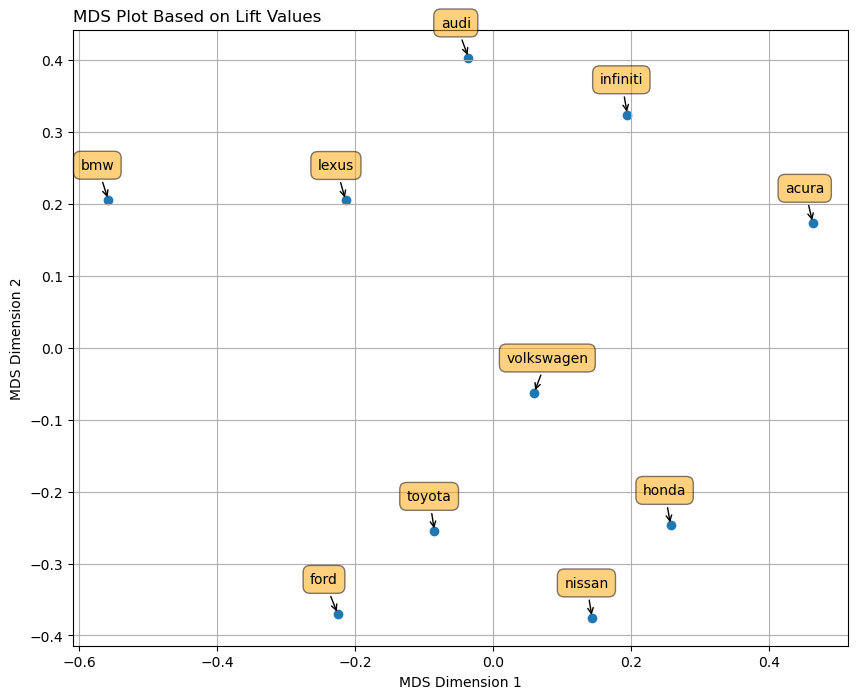

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

# Ensure `df_lift` is available and contains the lift values

# Pivot df_lift to create a matrix for dissimilarity
lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value').fillna(0)

# Invert the lift values to treat higher values as closer (distance)
# Use a small constant to avoid division by zero errors
dissimilarity_matrix = 1 / (lift_matrix + 1e-10)
np.fill_diagonal(dissimilarity_matrix.values, 0)  # Set diagonal to zero

# Multidimensional Scaling (MDS)
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
                   random_state=seed, dissimilarity="precomputed")

try:
    results = mds.fit(dissimilarity_matrix)
    coords = results.embedding_
except ValueError as e:
    print(f"Error during MDS fitting: {e}")
    coords = np.zeros((len(lift_matrix), 2))  # Placeholder in case of error

# Plotting the MDS results
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], marker='o')

# Annotate each point with the corresponding brand name
for label, x, y in zip(lift_matrix.index, coords[:, 0], coords[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-20, 20),
                 textcoords='offset points', ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Left-align the title
plt.title('MDS Plot Based on Lift Values', loc='left')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()


In [3]:
# Takeaways

- Volkswagen is a middle brand between beginner and entry level luxury cars
- Audi is talked about more with VW than any other brand
- Luxury brands are distinct while entry level are not

In viewing the MDS plot there arae two major clumps. The first is the more casual brands of VW, Nissan, Honda, then there are the luxury brands. These cluster indicate people see the luxury cars as different from the more entry level vehicles. Secondly, Volkswagen owners would be the best to target for shifting to a luxury brand. Volkswagon had the strongest lift with Audi while also having strong lifts with Nissian and Honda. In essence, Volkswagen could be considered a middle man brand between entry level and entry luxury based on the data.

Audi is another interesting brand since it's strongest lift happens to be between VW, but everything else is close to 1. People talk about Audi and VW more than Audi and other luxury brands. Therefore, Audi as a brand should use maarketing spend on VW users. 

Lastly, the luxury brands do not have as strong as a lift as the "more basic" brands do. It wold indiciate that there is a lack of people using luxury brands in the same post. The lack of lift could indicate that the people posting see the luxury brands as more distinct and in less need of comparison vs the entry level vehical brands. 

SyntaxError: invalid syntax (178385677.py, line 3)